To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


Huggiface login using token

In [2]:
from huggingface_hub import notebook_login

notebook_login()

To work with pre-trained language models and datasets.

In [3]:
!pip install -q datasets transformers

## Clone and Install

Using a fork of the main repository of yolo v9.

In [4]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9

# to quickly install all the dependencies for a Python project 
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 325 (delta 158), reused 155 (delta 155), pack-reused 109
Receiving objects: 100% (325/325), 2.23 MiB | 28.97 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/kaggle/working/yolov9


Need to install Git-LFS to upload your model checkpoints:

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [6]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.1.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.2 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is i

## Imports

In [7]:
import roboflow

from IPython.display import Image

## Download model weights

yolov9-s and yolov9-m are also mentioned in the paper but the weights for these models are not yet available in the YOLOv9 repository.

In [8]:
!mkdir -p {HOME}/weights

In [9]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [10]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 May  9 07:15 .
drwxr-xr-x 5 root root      4096 May  9 07:15 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


In [11]:
!mkdir -p {HOME}/data

## Authenticate and Download the Dataset

### Load Action Dataset 

In [12]:
from datasets import load_dataset
train_data = load_dataset("/kaggle/input/datasetactionnew/DatasetForAction(new)/train")
valid_data = load_dataset("/kaggle/input/datasetactionnew/DatasetForAction(new)/valid")
test_data = load_dataset("/kaggle/input/datasetactionnew/DatasetForAction(new)/test")

Resolving data files:   0%|          | 0/4288 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/569 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/509 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
ex1 = train_data['train'][880]
ex1

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'label': 1}

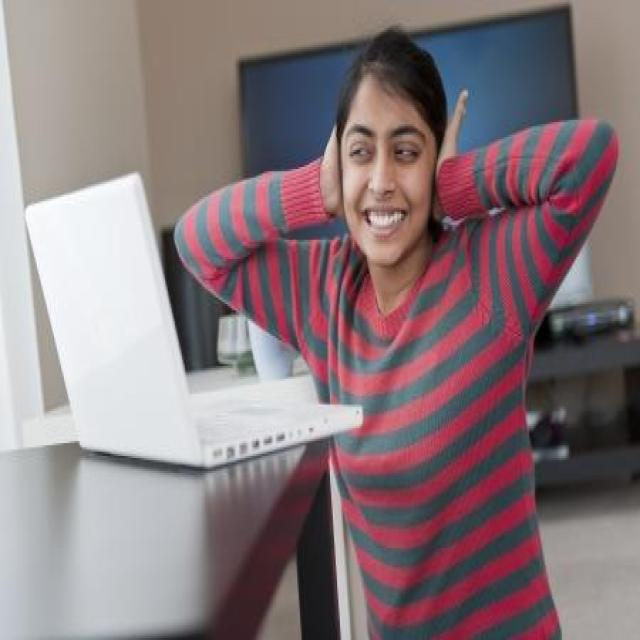

In [14]:
image1 = ex1['image']
image1

In [15]:
labels = train_data['train'].features['label']
labels

ClassLabel(names=['কথা_বলা', 'কম্পিউটার_ব্যবহার_করা', 'খাওয়া', 'খেলা_করা', 'ঘুমানো', 'পান_করা', 'পড়া', 'রান্না_করা', 'লেখা', 'হাঁটা'], id=None)

In [16]:
labels.int2str(ex1['label'])

'কম্পিউটার_ব্যবহার_করা'

In [17]:
len(labels.names)

10

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [18]:
from datasets import load_metric

metric = load_metric("accuracy")

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.


In [19]:
print(train_data)
print(test_data)
print(valid_data)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4288
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 509
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 569
    })
})


Another prepatory step is to create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [20]:
labels = train_data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Load google vit model as a pre-trained model

This is for microsoft/resnet-18

In [21]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
# model_name_or_path = 'timm/resnet50.a1_in1k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

2024-05-09 07:16:09.000230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 07:16:09.000329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 07:16:09.119911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to
(1) resizing them to a particular size
(2) normalizing the color channels (R,G,B) using a mean and standard deviation.

**data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy.

We will use `torchvision.transforms` but there are other packages also available (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [22]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    #data augmentation
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
        CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
        ToTensor(),
        normalize,
    ]
)



def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [43]:
# split up training into training + validation
train_ds = train_data['train']
val_ds = valid_data['train']
test_ds = test_data['train']

We can write custom functions, which can then be applied on an entire dataset [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

In [44]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

"pixel_values" feature:

In [25]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'label': 0,
 'pixel_values': tensor([[[-0.3255,  0.2314,  0.5059,  ..., -0.8902, -0.8745, -0.8431],
          [-0.3882,  0.1059,  0.4353,  ..., -0.8980, -0.8902, -0.8588],
          [-0.3569,  0.1294,  0.4431,  ..., -0.8980, -0.8902, -0.8667],
          ...,
          [ 0.0902,  0.0980,  0.0902,  ..., -0.2784, -0.2863, -0.2941],
          [ 0.0902,  0.0902,  0.0902,  ..., -0.4196, -0.4353, -0.4431],
          [ 0.0824,  0.0745,  0.0902,  ..., -0.5922, -0.6000, -0.6000]],
 
         [[-0.3020,  0.3098,  0.6314,  ..., -0.8431, -0.8275, -0.7961],
          [-0.3490,  0.1843,  0.5529,  ..., -0.8275, -0.8196, -0.7961],
          [-0.3176,  0.2000,  0.5529,  ..., -0.8275, -0.8196, -0.7961],
          ...,
          [ 0.1059,  0.1137,  0.1059,  ..., -0.3098, -0.3176, -0.3255],
          [ 0.1059,  0.1059,  0.1059,  ..., -0.4510, -0.4588, -0.4667],
          [ 0.0980,  0.0902,  0.1059,  ..., -0.6078, -0.6078, -0.6157]]

In [26]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from accelerate import Accelerator
from transformers import TrainingArguments

training_args = TrainingArguments(
    'Action_model',
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=10,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    hub_strategy="end"
)

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    #To show confusion matrix as well 
    #cm = confusion_matrix(eval_pred.label_ids, predictions)
    #accuracy = metric.compute(predictions=predictions, references=eval_pred.label_ids)
    #return {"accuracy": accuracy, "confusion_matrix": cm}
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [29]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

## Train Custom Model

In [30]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)


In [31]:

!python train_dual.py --workers 8 --batch 8  --img 640 --epochs 12 --data /kaggle/input/yamlfile/data.yaml --weights /kaggle/working/weights/yolov9-e.pt --device 0 --cfg /kaggle/working/yolov9/models/detect/yolov9-e.yaml --hyp /kaggle/working/yolov9/data/hyps/hyp.scratch-high.yaml

2024-05-09 07:16:27.549279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 07:16:27.549337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 07:16:27.550736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train_dual: weights=/kaggle/working/weights/yolov9-e.pt, cfg=/kaggle/working/yolov9/models/detect/yolov9-e.yaml, data=/kaggle/input/yamlfile/data.yaml, hyp=/kaggle/wor

In [32]:
#Action training 
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

events.out.tfevents.1715258519.361db62a36de.34.0:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3094873175GF
  train_loss               =       0.4554
  train_runtime            =   0:22:33.23
  train_samples_per_second =       31.687
  train_steps_per_second   =         1.98


## Examine Agent Training Results

In [33]:
!ls {HOME}/yolov9/runs/train/exp/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1715239021.361db62a36de.258.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


To show TensorBoard for action

In [36]:
!pip install tensorboard

In [37]:
%load_ext tensorboard
%tensorboard --logdir runs

## Validate Custom Model

In [38]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.8576
  eval_loss               =     0.4589
  eval_runtime            = 0:00:07.93
  eval_samples_per_second =     71.727
  eval_steps_per_second   =      9.076


In [39]:
# Define the file path
file_path = "/kaggle/working/yolov9/utils/general.py"

# Read the content of the file into a list of lines
with open(file_path, "r") as file:
    lines = file.readlines()

# Modify the specific line (line number starts from 0)
line_number = 902  # Line number 903 in 0-based indexing
replacement_line = "        prediction = prediction[0][1]\n"

# Replace the line
lines[line_number] = replacement_line

# Write the modified content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)


In [40]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 8 --conf 0.001 --iou 0.7 --device 0 \
--data /kaggle/input/yamlfile/data.yaml \
--weights /kaggle/working/yolov9/runs/train/exp/weights/last.pt

/kaggle/working/yolov9
val: data=/kaggle/input/yamlfile/data.yaml, weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], batch_size=8, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
val: Scanning /kaggle/input/final-dataset/Detection_action_agent_YolovFormat/Det
val: WARNING ⚠️ Cache directory /kaggle/input/final-dataset/Detection_action_agent_YolovFormat/Detection_action_agent_YolovFormat/valid is not writeable: [Errno 30] Read-only file system: '/kaggle/input/final-dataset/Detection_action_agent_YolovFormat/Detection_action_agent_YolovFormat/valid/labels.cache.

# Testing and confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


test_predictions = trainer.predict(test_ds)

predictions = np.argmax(test_predictions.predictions, axis=1)

true_labels = test_predictions.label_ids

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_report = classification_report(true_labels, predictions)
print("Classification Report:")
print(class_report)

In [46]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'action_class',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1715259917.361db62a36de.34.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [51]:
import zipfile
import os

def zip_dir(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

folder_path = "/kaggle/working/data"
zip_path = "/kaggle/working/YoloV9e_Data.zip"

zip_dir(folder_path, zip_path)


In [53]:
folder_path = "/kaggle/working/yolov9/runs"
zip_path = "/kaggle/working/YoloV9e_runs.zip"

zip_dir(folder_path, zip_path)

In [58]:
import shutil

# Define the source path of the zip file
source_zip_file = "/kaggle/working/YoloV9e_runs.zip"

# Define the destination directory where you want to download the zip file
destination_directory = "E:\\Download Here"  # Use double backslashes for Windows paths

# Copy the zip file from the source path to the destination directory
shutil.copy(source_zip_file, destination_directory)

print("Zip file downloaded successfully to:", destination_directory)


Zip file downloaded successfully to: E:\Download Here


## Inference with Custom Model

In [48]:
import os
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from PIL import Image
import torch

# Load model and feature extractor
repo_name = "Raihan004/Action_model"
feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

## This code should run after running the below code and got error.

In [ ]:
import os

directory_to_clear = "/kaggle/working/yolov9/runs/detect"

def clear_directory(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    # Remove the target directory itself
    os.rmdir(directory)

clear_directory(directory_to_clear)

os.makedirs(directory_to_clear)


### Inference for folder of images

detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/dog_reading-116-_jpg.rf.8b9092147431adb6d025aa8b27a172af.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/dog_reading-116-_jpg.rf.8b9092147431adb6d025aa8b27a172af.jpg: 640x640 1 কুকুর, 3 মানুষs, 61.4ms
Speed: 0.5ms pre-process, 61.4ms inference, 307.5ms NMS per image at shape (1, 3, 640, 640)
Re

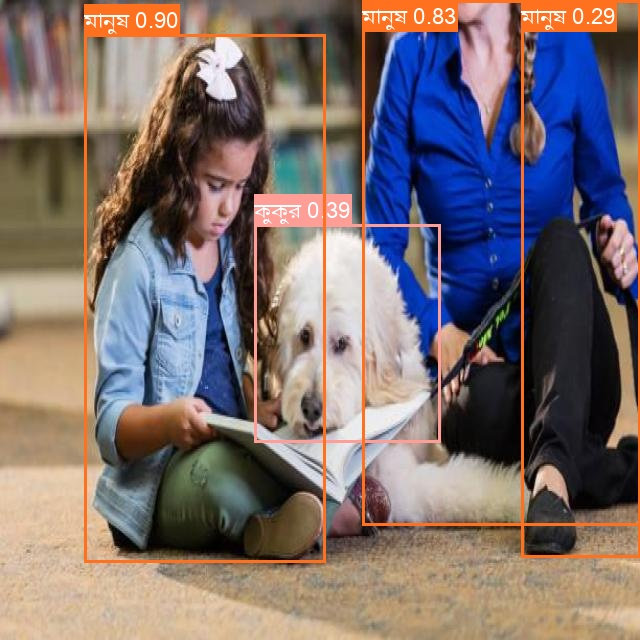

Predicted Action:  পড়া


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/cat_playing-18-_jpg.rf.9eafc489f20cf0bb0e238eb2b0de4120.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/cat_playing-18-_jpg.rf.9eafc489f20cf0bb0e238eb2b0de4120.jpg: 640x640 1 বিড়াল, 60.3ms
Speed: 0.6ms pre-process, 60.3ms inference, 301.5ms NMS per image at shape (1, 3

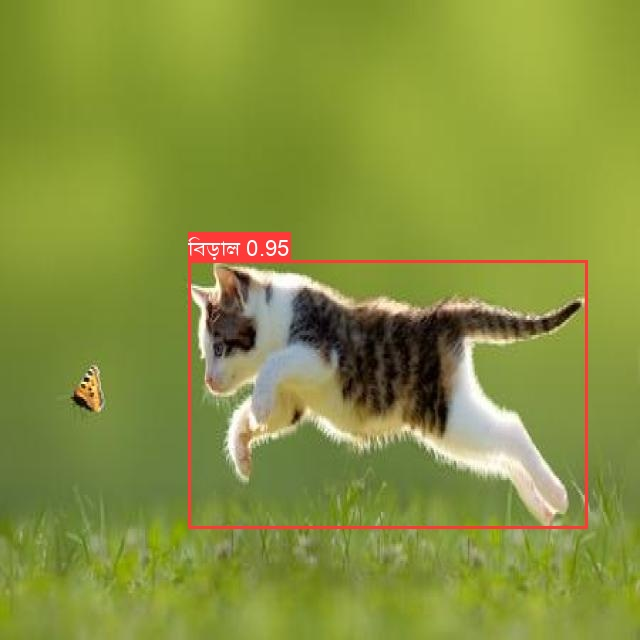

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/dog_writing-53-_jpg.rf.bbd51b601d4ca67b51b4a8e038558b20.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/dog_writing-53-_jpg.rf.bbd51b601d4ca67b51b4a8e038558b20.jpg: 640x640 1 কুকুর, 1 মানুষ, 58.7ms
Speed: 0.5ms pre-process, 58.7ms inference, 296.4ms NMS per image a

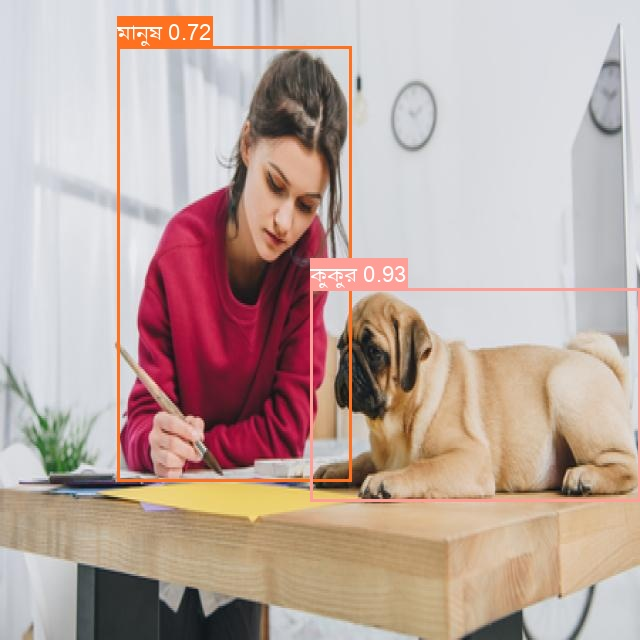

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_playing-53-_jpg.rf.706b5d92ac4e55aa2e0c38a4a4496136.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_playing-53-_jpg.rf.706b5d92ac4e55aa2e0c38a4a4496136.jpg: 640x640 1 মানুষ, 55.9ms
Speed: 0.5ms pre-process, 55.9ms inference, 328.9ms NMS per image at shape (1, 3

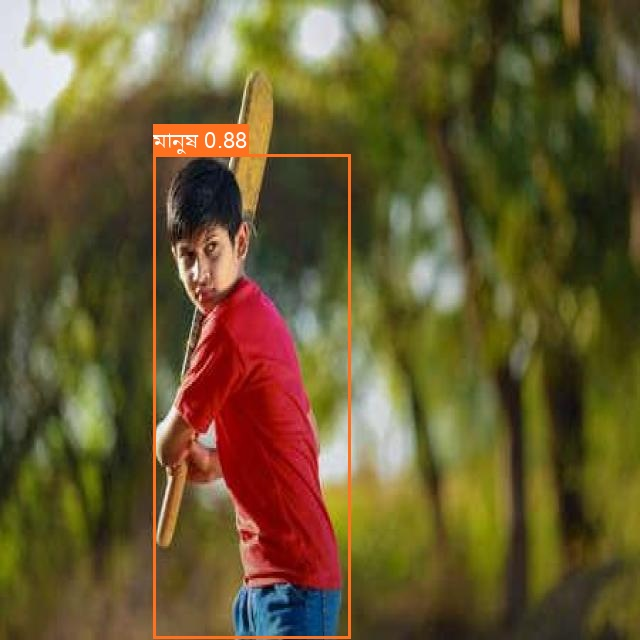

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/girl_playing-23-_jpg.rf.f4e2bc5963ab577e1a783c1048f10a67.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/girl_playing-23-_jpg.rf.f4e2bc5963ab577e1a783c1048f10a67.jpg: 640x640 1 মানুষ, 56.0ms
Speed: 0.5ms pre-process, 56.0ms inference, 314.8ms NMS per image at shape

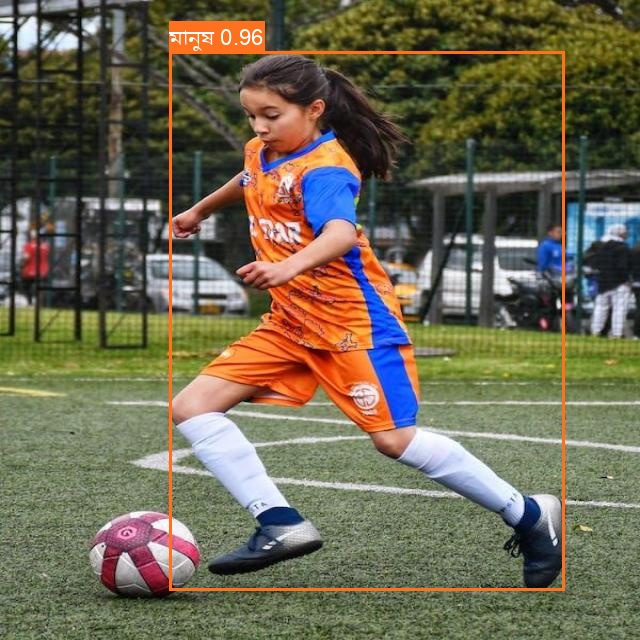

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/cat_computer-17-_jpg.rf.4290f9235bd3c7cab35f06304674591d.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/cat_computer-17-_jpg.rf.4290f9235bd3c7cab35f06304674591d.jpg: 640x640 1 বিড়াল, 56.3ms
Speed: 0.6ms pre-process, 56.3ms inference, 326.2ms NMS per image at shap

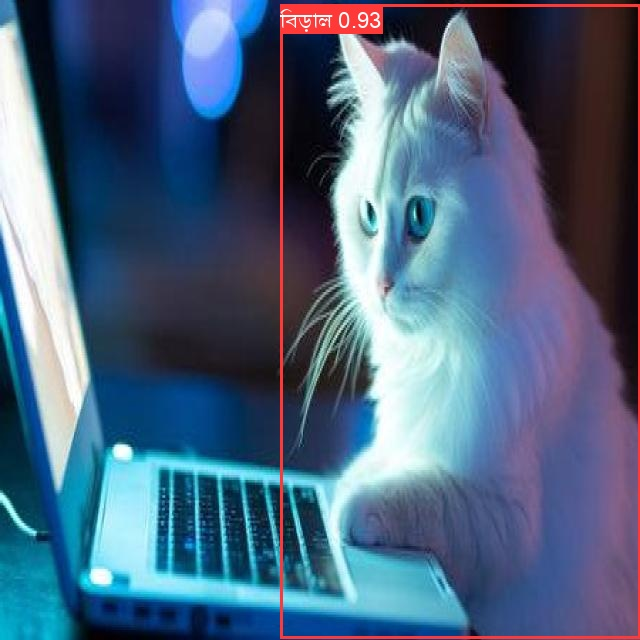

Predicted Action:  কম্পিউটার_ব্যবহার_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/cat_writing-15-_jpeg.rf.f22fed4c2c644946aed5b96fe407d6fe.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/cat_writing-15-_jpeg.rf.f22fed4c2c644946aed5b96fe407d6fe.jpg: 640x640 2 মানুষs, 59.6ms
Speed: 0.5ms pre-process, 59.6ms inference, 420.6ms NMS per 

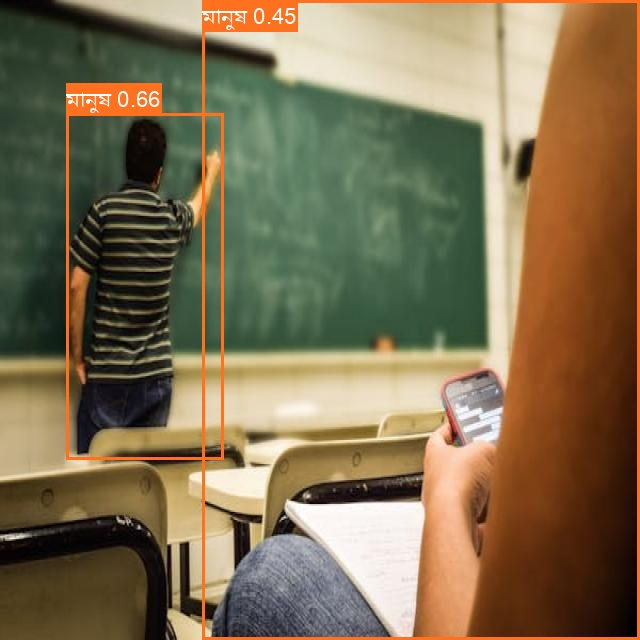

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_computer-6-_jpg.rf.a67372bb54edd21f75dd3923762275c9.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_computer-6-_jpg.rf.a67372bb54edd21f75dd3923762275c9.jpg: 640x640 1 মানুষ, 56.1ms
Speed: 0.6ms pre-process, 56.1ms inference, 403.2ms NMS per image at shape (1, 3

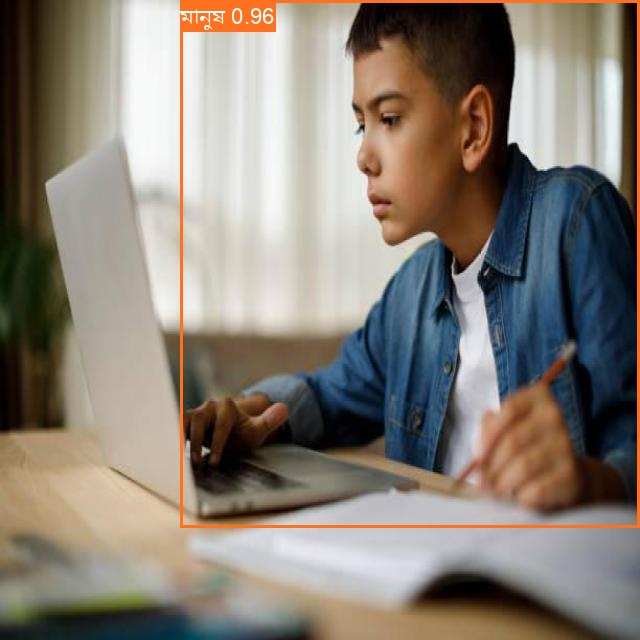

Predicted Action:  কম্পিউটার_ব্যবহার_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/shakib1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/shakib1.jpg: 448x640 1 মানুষ, 109.5ms
Speed: 0.5ms pre-process, 109.5ms inference, 364.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


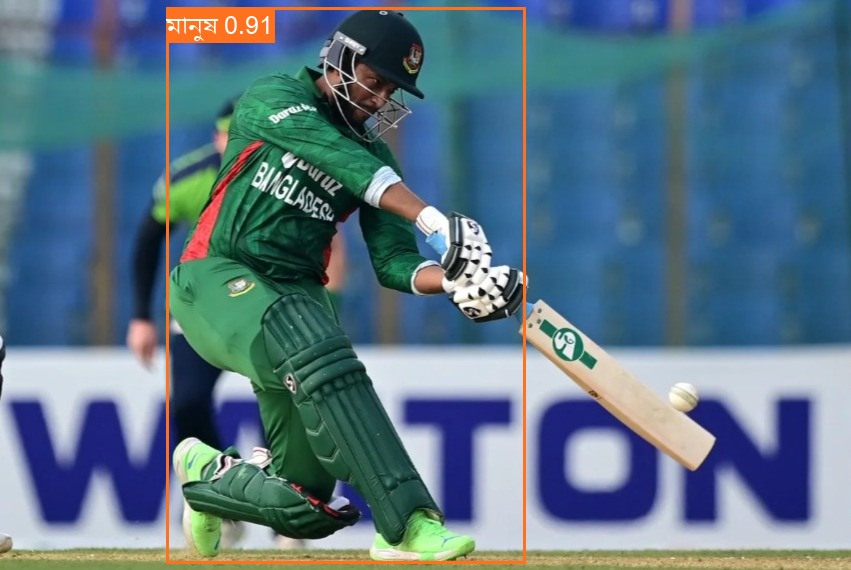

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_writing-33-_jpg.rf.36b99d5220f80295a3b2352ff8e13725.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_writing-33-_jpg.rf.36b99d5220f80295a3b2352ff8e13725.jpg: 640x640 1 মানুষ, 56.2ms
Speed: 0.5ms pre-process, 56.2ms inference, 369.1ms NMS per image at shape (

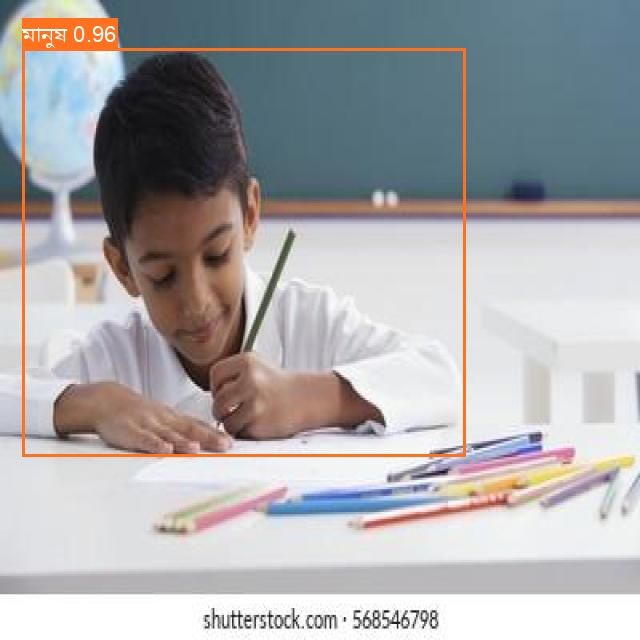

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/shakib2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/shakib2.jpg: 448x640 1 মানুষ, 111.7ms
Speed: 0.6ms pre-process, 111.7ms inference, 365.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


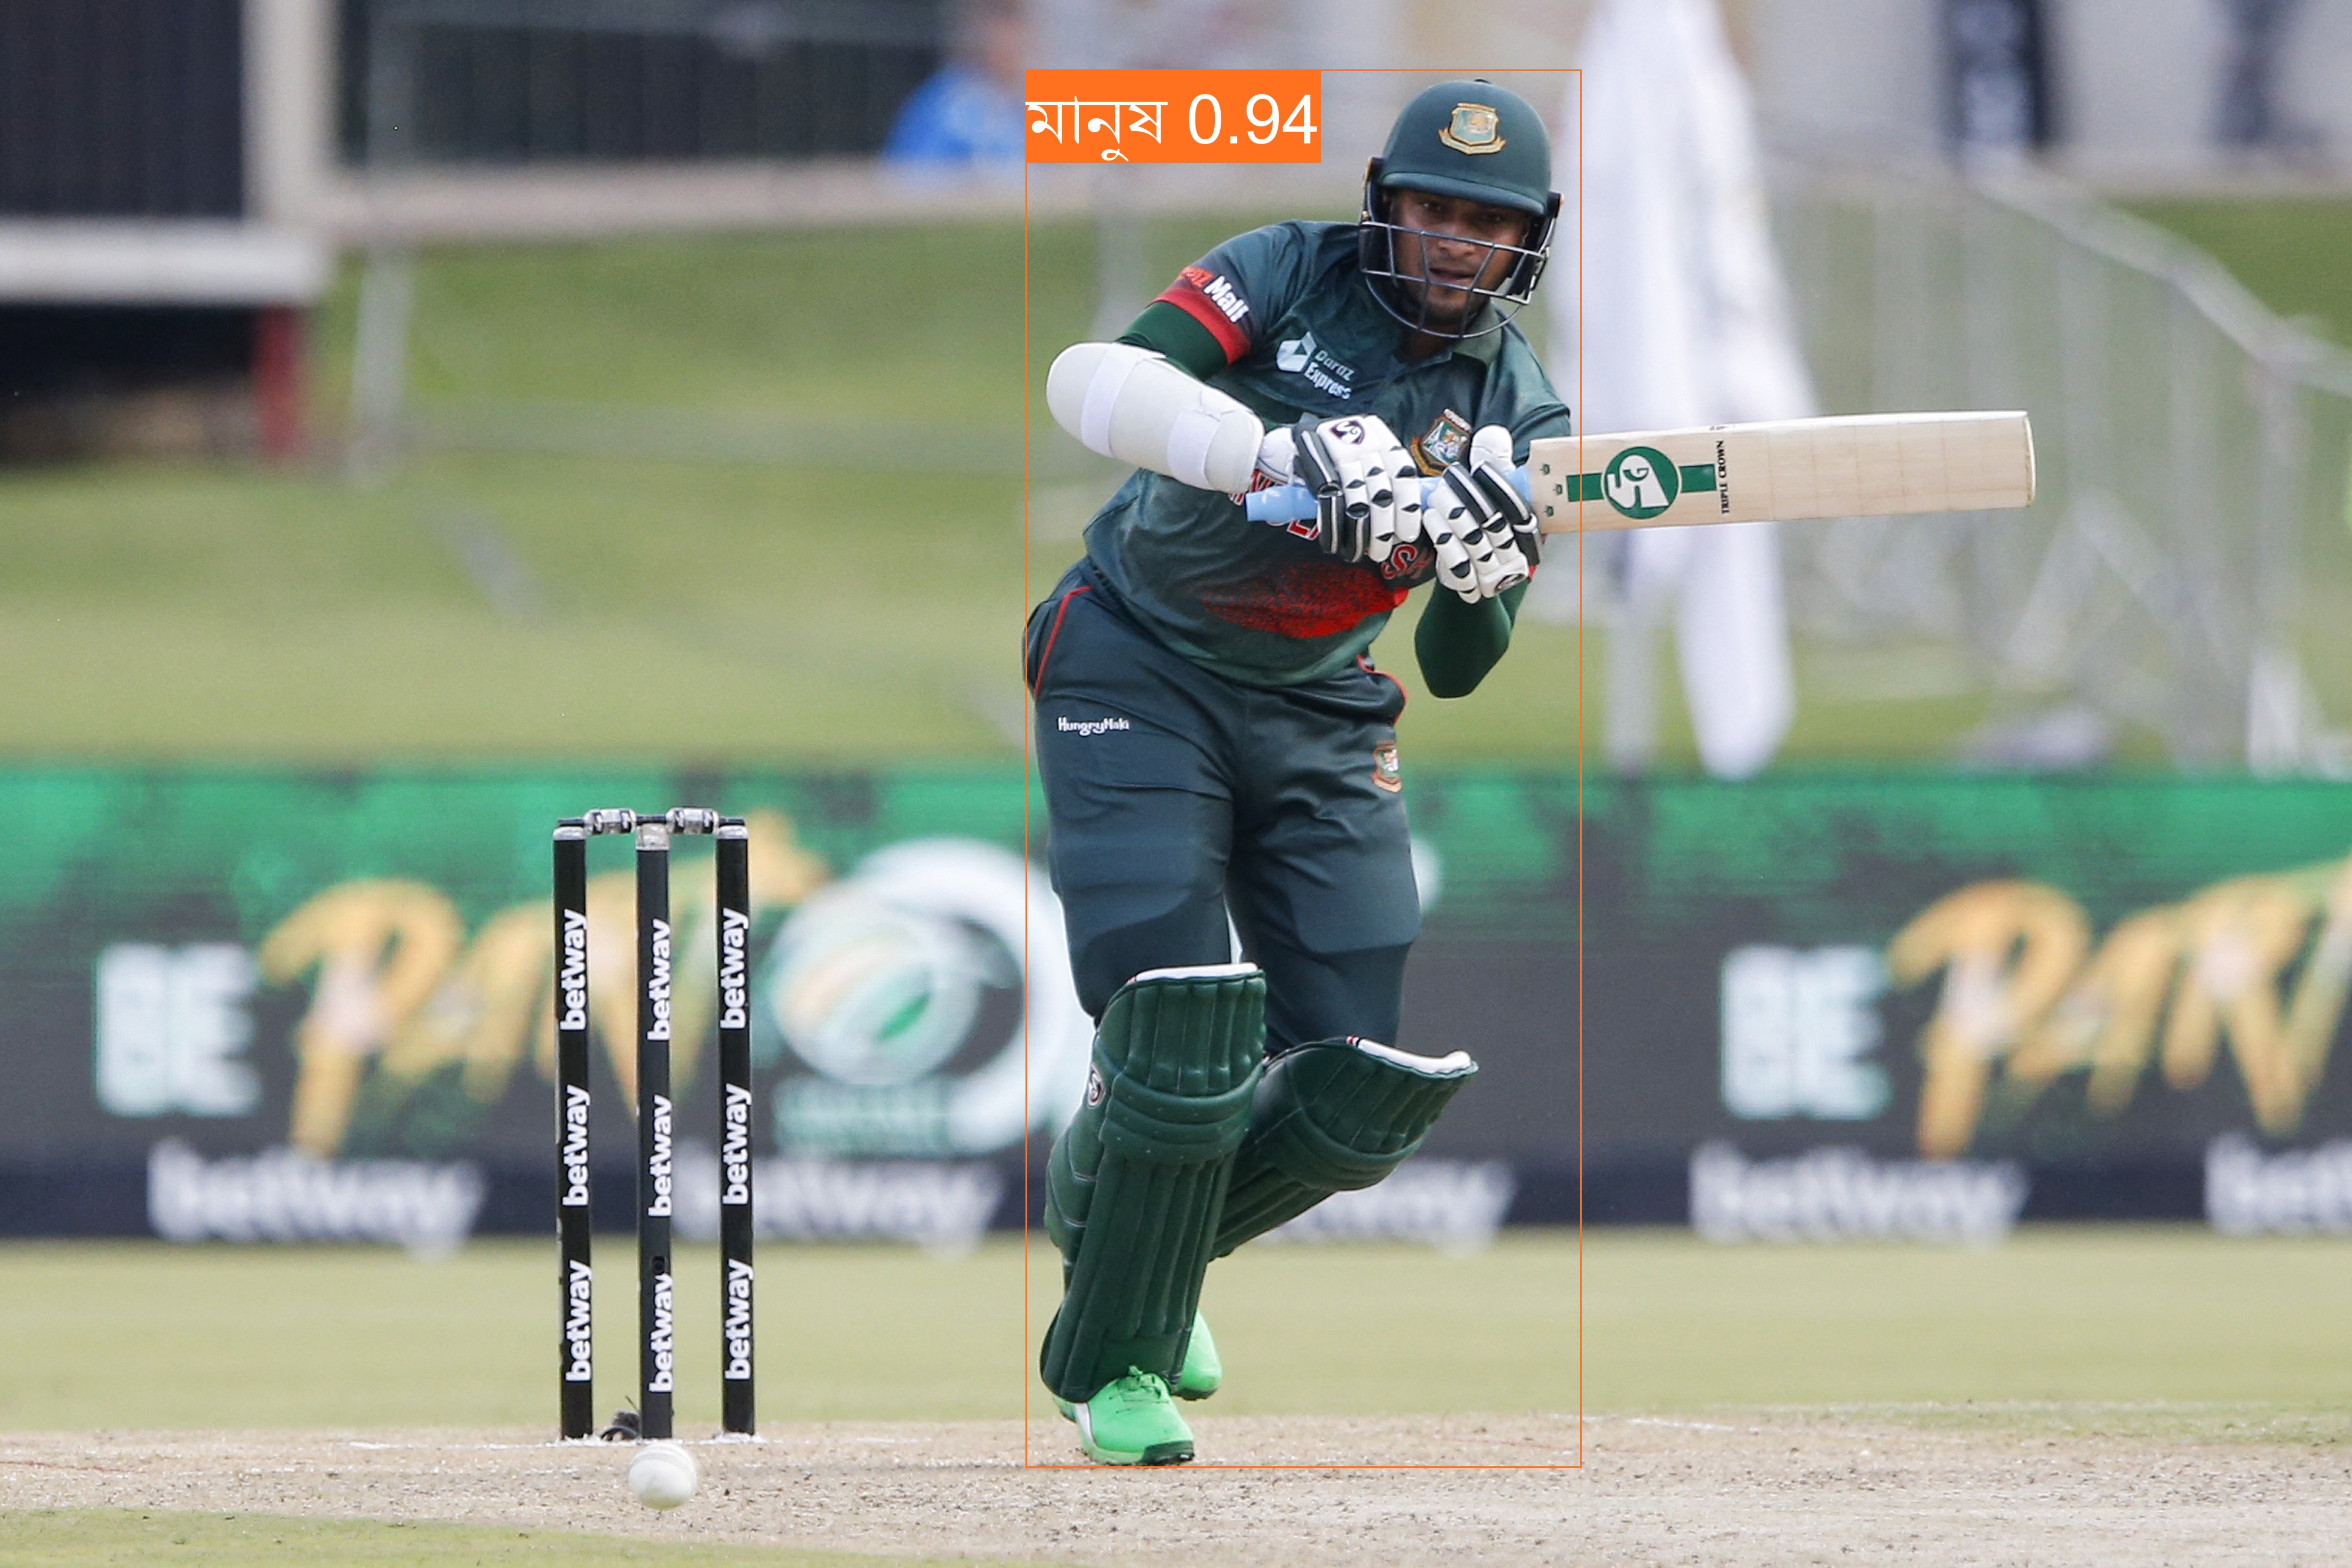

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_reading-102-_jpg.rf.17945bb96903246dd35cb09d648016b7.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_reading-102-_jpg.rf.17945bb96903246dd35cb09d648016b7.jpg: 640x640 4 মানুষs, 61.3ms
Speed: 0.6ms pre-process, 61.3ms inference, 353.9ms NMS per image at shap

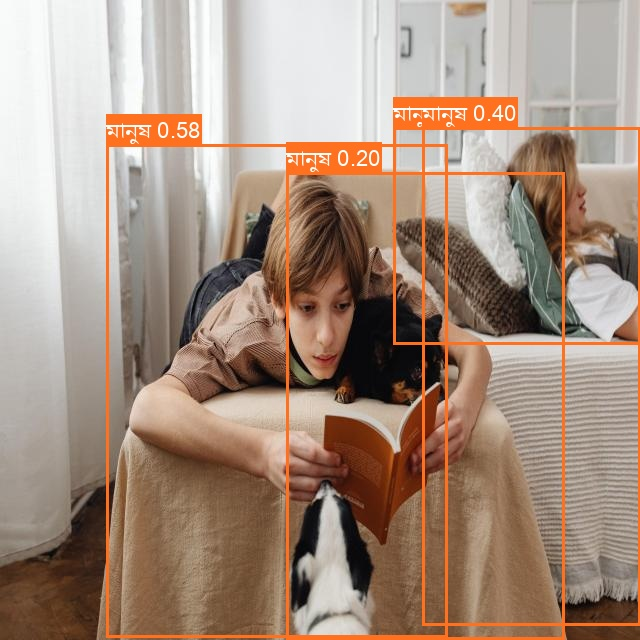

Predicted Action:  পড়া


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/dog_writing-94-_jpg.rf.1e196b2651c13d84472cfbe420d586fb.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/dog_writing-94-_jpg.rf.1e196b2651c13d84472cfbe420d586fb.jpg: 640x640 1 মানুষ, 56.0ms
Speed: 0.5ms pre-process, 56.0ms inference, 312.2ms NMS per image at shape (1, 3,

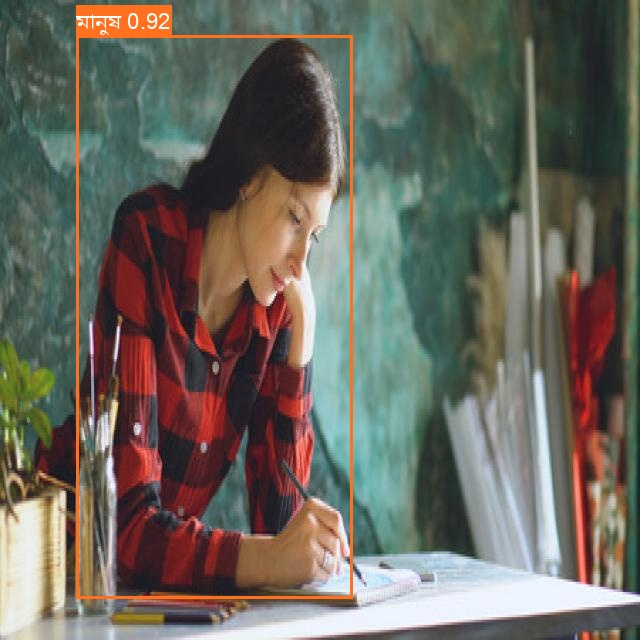

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_playing-9-_jpg.rf.1f50df60376081f96f625a3c866fa711.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_playing-9-_jpg.rf.1f50df60376081f96f625a3c866fa711.jpg: 640x640 2 মানুষs, 56.0ms
Speed: 0.6ms pre-process, 56.0ms inference, 305.8ms NMS per image at shape (1, 3,

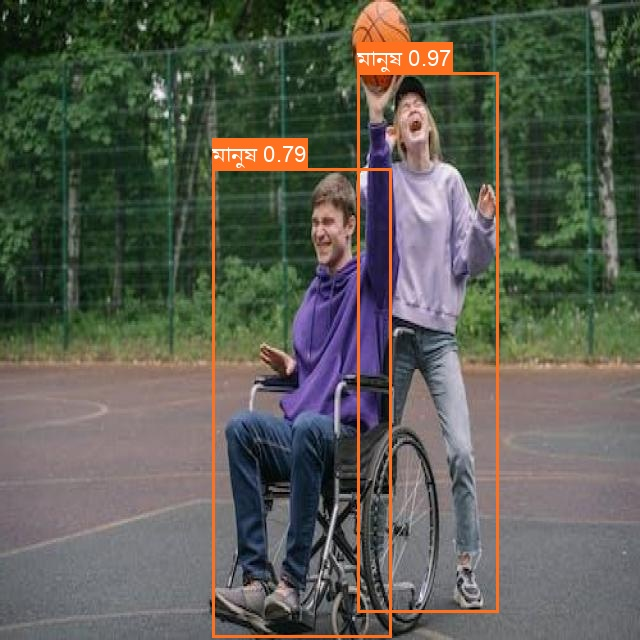

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/girl_writing-28-_jpg.rf.2a858f3a54671ea07b22091d0b62396d.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/girl_writing-28-_jpg.rf.2a858f3a54671ea07b22091d0b62396d.jpg: 640x640 1 মানুষ, 56.1ms
Speed: 0.5ms pre-process, 56.1ms inference, 346.0ms NMS per image at shape

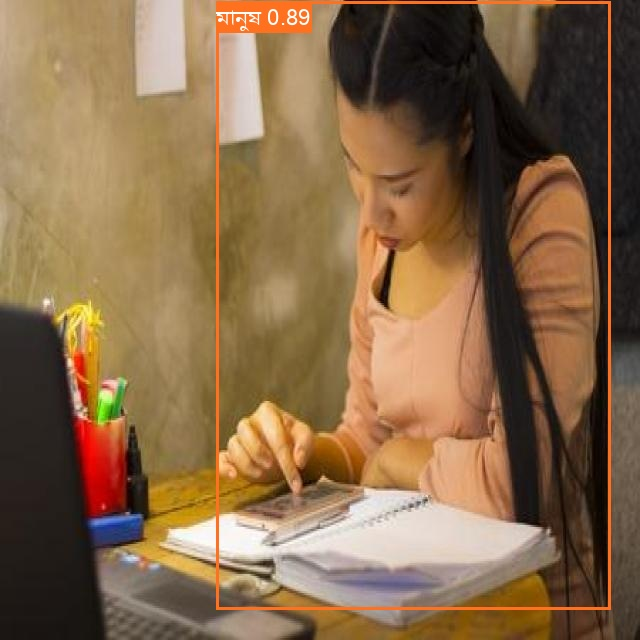

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_playing-20-_jpg.rf.4bd830f79aeac230ff5d7554d0324244.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_playing-20-_jpg.rf.4bd830f79aeac230ff5d7554d0324244.jpg: 640x640 1 মানুষ, 61.3ms
Speed: 0.5ms pre-process, 61.3ms inference, 308.2ms NMS per image at shape (1, 3

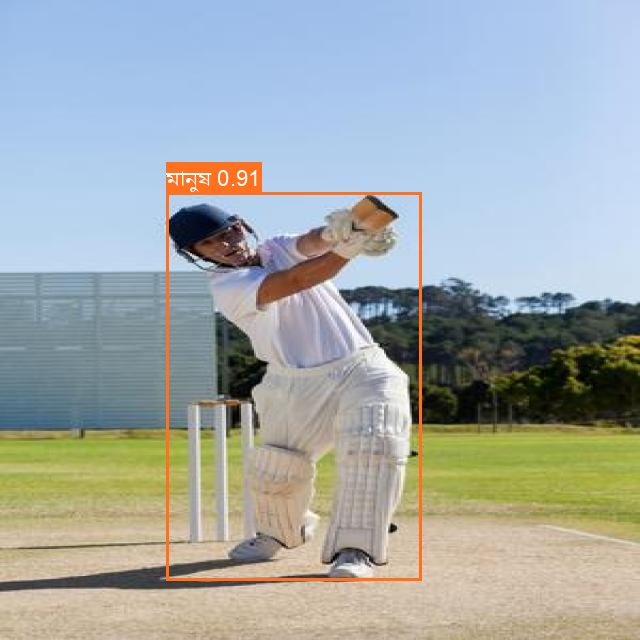

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/cat_playing-67-_jpg.rf.2b0e19162a1654fe4524b6d5735c75a3.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/cat_playing-67-_jpg.rf.2b0e19162a1654fe4524b6d5735c75a3.jpg: 640x640 1 বিড়াল, 56.3ms
Speed: 0.5ms pre-process, 56.3ms inference, 409.1ms NMS per image at shape 

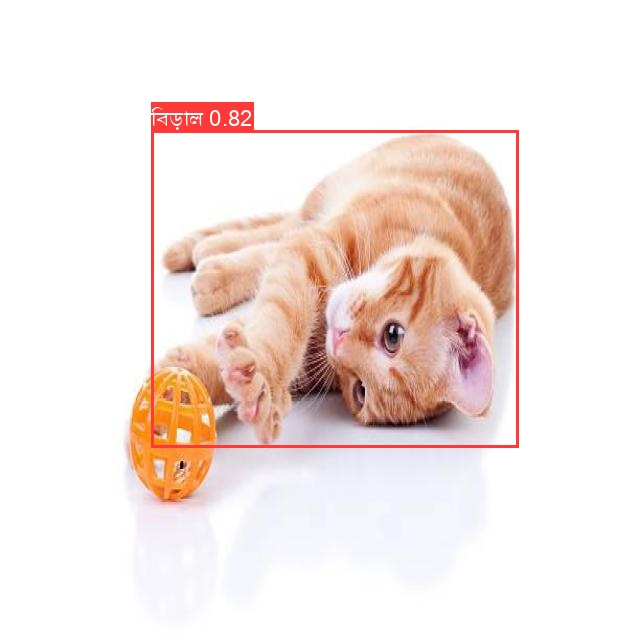

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_writing-1-_jpg.rf.6079f636412ff3fd45b8eac8d64e5096.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_writing-1-_jpg.rf.6079f636412ff3fd45b8eac8d64e5096.jpg: 640x640 1 মানুষ, 56.1ms
Speed: 0.5ms pre-process, 56.1ms inference, 361.0ms NMS per image at shape (1,

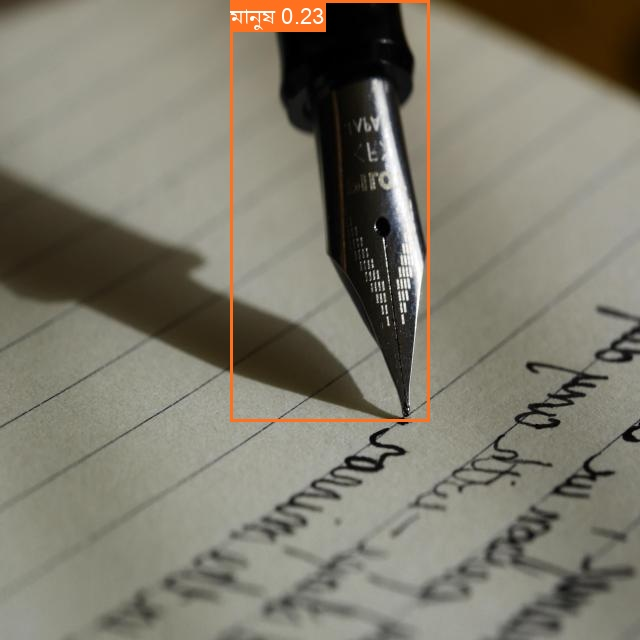

Predicted Action:  লেখা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/dog_playing-3-_jpg.rf.c7ecd1c3343b4a7cc2fc9bcb12596a11.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/dog_playing-3-_jpg.rf.c7ecd1c3343b4a7cc2fc9bcb12596a11.jpg: 640x640 1 কুকুর, 1 মানুষ, 55.9ms
Speed: 0.6ms pre-process, 55.9ms inference, 485.3ms NMS per image at shap

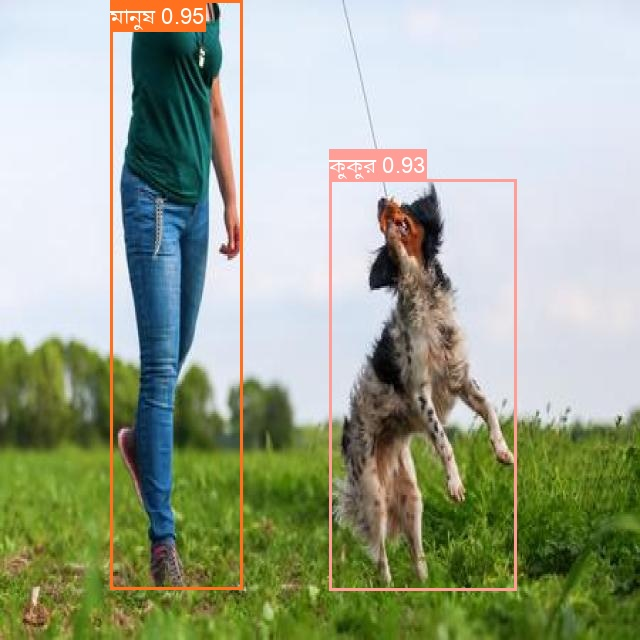

Predicted Action:  খেলা_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_computer-61-_jpg.rf.053cb5e653707b7ecfc6891dfbc7716e.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_computer-61-_jpg.rf.053cb5e653707b7ecfc6891dfbc7716e.jpg: 640x640 1 মানুষ, 61.3ms
Speed: 0.5ms pre-process, 61.3ms inference, 430.9ms NMS per image at shape

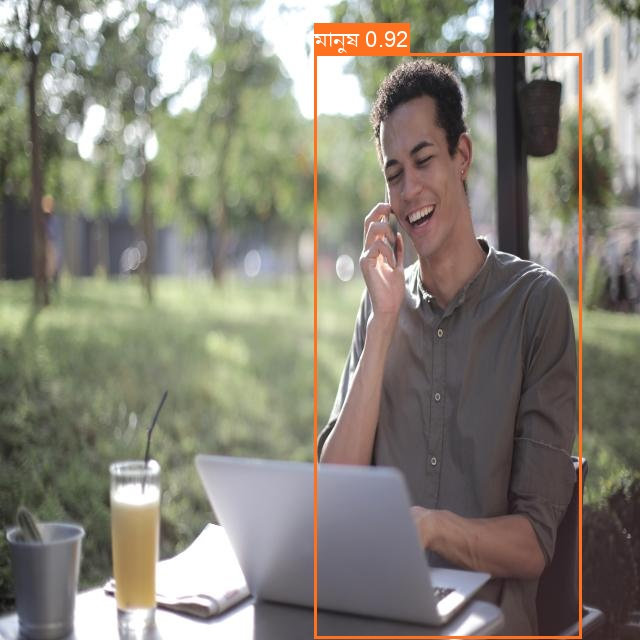

Predicted Action:  কম্পিউটার_ব্যবহার_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/girl_computer-90-_jpg.rf.4cacb38536992e579c4d7063c4c16484.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/girl_computer-90-_jpg.rf.4cacb38536992e579c4d7063c4c16484.jpg: 640x640 1 মানুষ, 61.3ms
Speed: 0.5ms pre-process, 61.3ms inference, 305.3ms NMS per

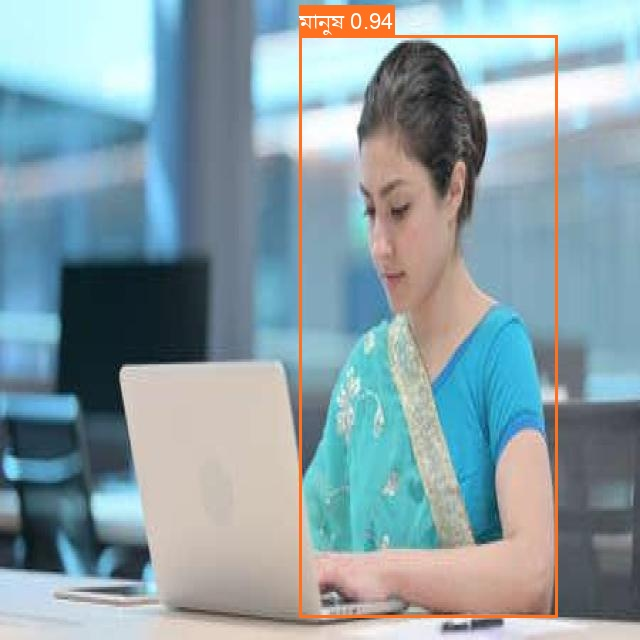

Predicted Action:  কম্পিউটার_ব্যবহার_করা


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/inferences/inferenceImage/boy_writing-41-_jpg.rf.60b41ac2b02f2348d3274fd44d35efd8.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/inferences/inferenceImage/boy_writing-41-_jpg.rf.60b41ac2b02f2348d3274fd44d35efd8.jpg: 640x640 1 মানুষ, 61.2ms
Speed: 0.5ms pre-process, 61.2ms inference, 365.4ms NMS per ima

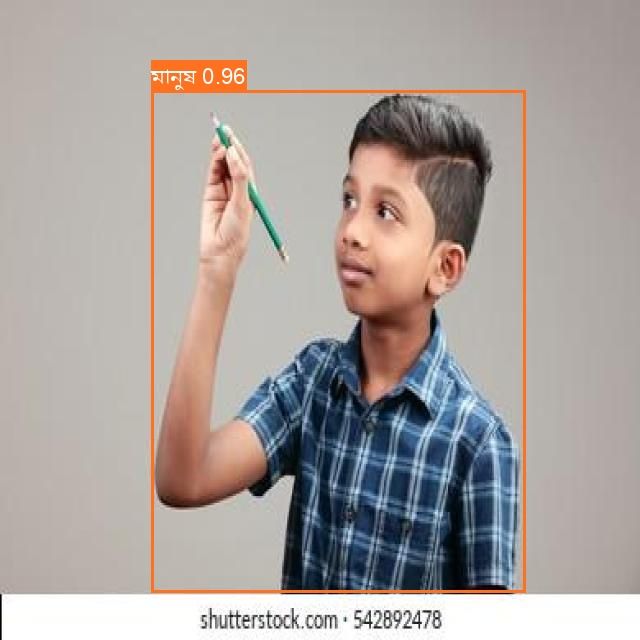

Predicted Action:  লেখা




In [56]:
import glob
from IPython.display import Image, display
import matplotlib.pyplot as plt
import torch
from PIL import Image as PILImage

# Define the path to the YOLOv9 detection script
detection_script = "/kaggle/working/yolov9/detect.py"

# Define the path to the model weights
weights_path = "/kaggle/working/yolov9/runs/train/exp/weights/last.pt"

# Define the path to the directory containing the images
image_source_path = "/kaggle/input/inferences/inferenceImage"

# Run detection and classification on each image in the directory
for image_file in glob.glob(os.path.join(image_source_path, "*.jpg")):
    # Run YOLOv9 detection on the current image
    !python {detection_script} \
    --img 640 --conf 0.1 --device 0 \
    --weights {weights_path} \
    --source {image_file}

    # Construct the output image path
    output_image_path = os.path.join("/kaggle/working/yolov9/runs/detect/exp", os.path.basename(image_file))

    # Display the output image from YOLOv9 detection
    display(Image(filename=output_image_path, width=600))
    
    # Load the image for classification
    image = PILImage.open(image_file)
    
    # Prepare image for the model
    encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    # Get predicted class
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted Action: ",model.config.id2label[predicted_class_idx])
    print("\n")
    # Define the path to the directory to be cleared
    directory_to_clear = "/kaggle/working/yolov9/runs/detect"

    # Function to clear directory recursively
    def clear_directory(directory):
        for root, dirs, files in os.walk(directory, topdown=False):
            for file in files:
                os.remove(os.path.join(root, file))
            for dir in dirs:
                os.rmdir(os.path.join(root, dir))
        # Remove the target directory itself
        os.rmdir(directory)

    # Clear the directory
    clear_directory(directory_to_clear)

    # Recreate the directory
    os.makedirs(directory_to_clear)

### Inference for single image


detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/last.pt'], source=/kaggle/input/shakib/shakib2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
image 1/1 /kaggle/input/shakib/shakib2.jpg: 448x640 1 মানুষ, 121.4ms
Speed: 0.6ms pre-process, 121.4ms inference, 337.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


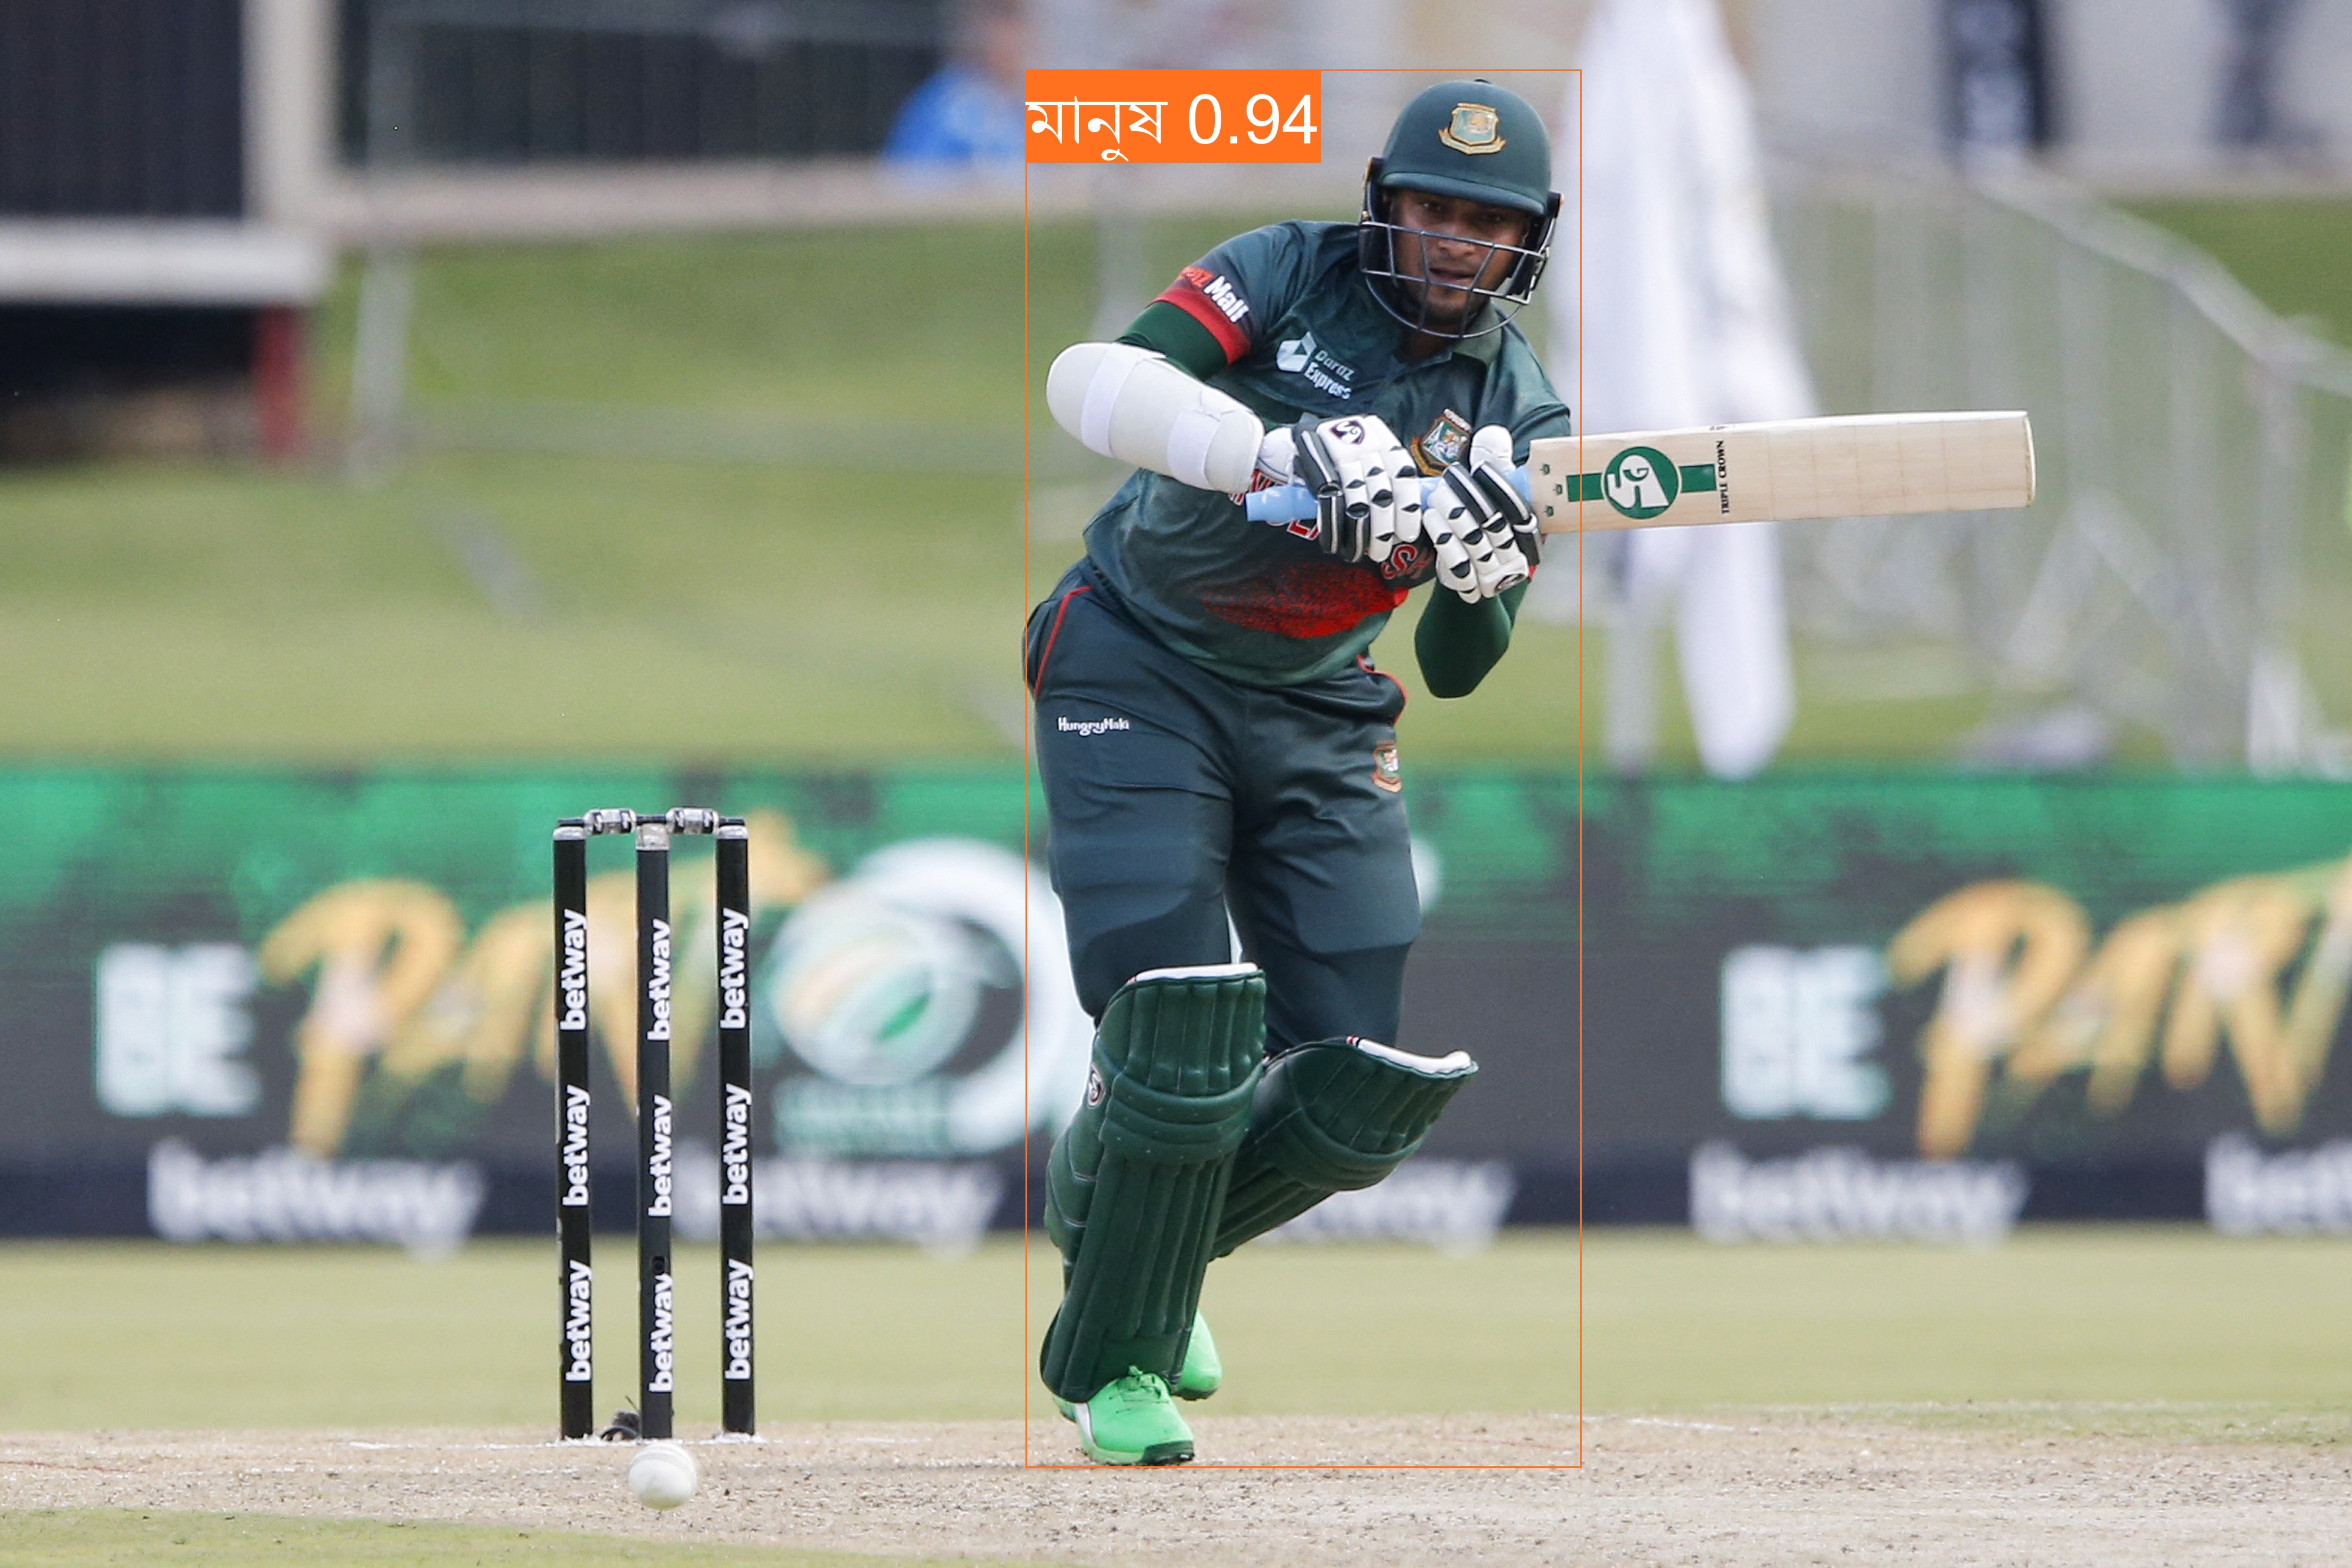

Predicted Action:  খেলা_করা


In [55]:
import os
import torch
from IPython.display import Image, display
from PIL import Image as PILImage

# Define the path to the YOLOv9 detection script
detection_script = "/kaggle/working/yolov9/detect.py"

# Define the path to the model weights
weights_path = "/kaggle/working/yolov9/runs/train/exp/weights/last.pt"

# Define the path to the input image
image_file = "/kaggle/input/shakib/shakib2.jpg"

# Run YOLOv9 detection on the image
!python {detection_script} \
--img 640 --conf 0.1 --device 0 \
--weights {weights_path} \
--source {image_file}

# Display the output image from YOLOv9 detection
output_image_path = os.path.join("/kaggle/working/yolov9/runs/detect/exp", os.path.basename(image_file))

display(Image(filename=output_image_path, width=600))

# Load the image for classification
image = PILImage.open(image_file)

# Prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

# Get predicted class
predicted_class_idx = logits.argmax(-1).item()
print("Predicted Action: ", model.config.id2label[predicted_class_idx])

# Define the path to the directory to be cleared
directory_to_clear = "/kaggle/working/yolov9/runs/detect"

# Function to clear directory recursively
def clear_directory(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    # Remove the target directory itself
    os.rmdir(directory)

# Clear the directory
clear_directory(directory_to_clear)

# Recreate the directory
os.makedirs(directory_to_clear)
